# How robusts are tests of anisotropy made through a 2-points correlation function?

_Paul Martens_

2025

## Preamble

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.stats import skewnorm as scipy_skewnorm
from scipy.stats import norm as scipy_norm

## Generating point distributions on a sphere

In [2]:
def generate_isotropic_pt_distrib(n_pts):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` isotropically distributed points, *on a sphere*
    """
    vec = np.random.normal(size=(3, n_pts))
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [3]:
def generate_half_sphere_pt_distrib(n_pts):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` isotropically distributed points, *on the z>0 hemisphere*
    """
    xyz = generate_isotropic_pt_distrib(n_pts)
    return np.vstack((
        xyz[0, :],
        xyz[1, :],
        np.array([z if z > 0 else -z for z in xyz[2, :]])
    ))

In [4]:
# /!\ This function is pretty inefficient
def generate_two_poles_pt_distrib(n_pts):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` isotropically distributed points, *on the |z|>1/2 hemispheres*
    """

    vec = np.empty((3, n_pts))
    abc = 2*np.random.rand(3, n_pts)-1
    norms = np.linalg.norm(abc, axis=0)
    mymask = np.logical_and(norms <= 1, abs(abc[2, :]) > 0.5)
    abc = abc[:,mymask]/norms[mymask]
    k = abc.shape[1]
    vec[:,0:k] = abc
    while k < n_pts:
       abc = 2*np.random.rand(3)-1
       norm = np.linalg.norm(abc)
       if np.logical_and(1e-5 <= norm <= 1, abs(abc[2]) > 0.5):
           vec[:,k] = abc/norm
           k = k+1
    return vec
# adapted from https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere

In [5]:
# /!\ This function is pretty inefficient
def generate_toroidal_pt_distrib(n_pts, radius=0.0):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate
    radius : float
        Radius of the hole in the sphere, by default 0.0 (no hole)

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` isotropically distributed points, *such that x^2+y^2 > radius^2*
    """
    vec = np.empty((3, n_pts))
    abc = 2*np.random.rand(3, n_pts)-1
    norms = np.linalg.norm(abc, axis=0)
    xynorms = np.linalg.norm(abc[:2, :], axis=0)
    mymask = np.logical_and(norms <= 1, xynorms > radius)
    abc = abc[:,mymask]/norms[mymask]
    k = abc.shape[1]
    vec[:,0:k] = abc
    while k < n_pts:
       abc = 2*np.random.rand(3)-1
       norm = np.linalg.norm(abc)
       xynorms = np.linalg.norm(abc[:1])
       if np.logical_and(1e-5 <= norm <= 1, xynorms > radius):
           vec[:,k] = abc/norm
           k = k+1
    return vec
# adapted from https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere

In [6]:
def generate_skewed_pt_distrib(n_pts, skewness=0.0):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate
    skewness : float, optional
        `a` argument of the scipy.stats.skewnorm.rvs,
        by default 0.0 (that is not skewed)

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` anisotropically distributed points along z only according to a
        skewed normal distribution, *on a sphere*
    """
    vec = np.vstack((
        np.random.normal(size=(2, n_pts)),
        scipy_skewnorm.rvs(skewness, size=(1, n_pts))
    ))
    vec /= np.linalg.norm(vec, axis=0)
    return vec
# https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9469.2005.00426.x

In [7]:
def generate_shifted_pt_distrib(n_pts, shift=0.0):
    """
    Parameters
    ----------
    n_pts : int
        Number of points to generate
    shift : float, optional
        `a` argument of the scipy.stats.skewnorm.rvs,
        by default 0.0 (that is not skewed)

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` matrix whose columns are the Cartesian coordinates of
        `n_pts` anisotropically distributed points along z only according to a
        normal distribution shifted by `shift`, *on a sphere*
    """
    vec = np.vstack((
        np.random.normal(size=(2, n_pts)),
        np.random.normal(size=(1, n_pts)) + shift
    ))
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [8]:
def generate_multipole_pt_distrib(n_pts, l=0, m=0):
    """
    NOT IMPLEMENTED

    Parameters
    ----------
    n_pts : _type_
        _description_
    l : int, optional
        _description_, by default 0
    m : int, optional
        _description_, by default 0

        Raises
    ------
    ValueError
        `m` must be smaller or equal to `l`
    """
    if m > l:
        raise ValueError("`m` must be smaller or equal to `l`")
    raise NotImplementedError("Need to look up how to do it nicely")

### Visual checks

In [9]:
def add_subplot_of_cart_pts(pts, fig=None, ax=None):
    """Creates a 3D scatter plot of the `pts` given in Cartesian coordinates and
    assumed to be 3 by `n_pts`"""
    if fig==None:
        fig = plt.figure()
    if ax==None:
        ax = fig.add_subplot(projection="3d")
    ax.scatter(pts[0,:], pts[1, :], pts[2, :], marker="o", s=0.5)
    ax.set_aspect("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return (fig, ax)

#### One-by-one

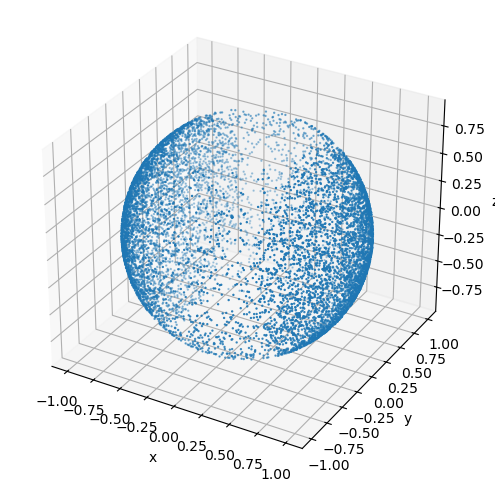

In [10]:
n_pts = 10000
# cart_pts = generate_isotropic_pt_distrib(n_pts)
# cart_pts = generate_half_sphere_pt_distrib(n_pts)
# cart_pts = generate_two_poles_pt_distrib(n_pts)
# cart_pts = generate_skewed_pt_distrib(n_pts, 0.1) # Imperceptible
# cart_pts = generate_skewed_pt_distrib(n_pts, 1.0) # Barely noticeable
# cart_pts = generate_skewed_pt_distrib(n_pts, 2.0) # Clear
cart_pts = generate_toroidal_pt_distrib(n_pts, 0.5)
# cart_pts = generate_skewed_pt_distrib(n_pts, 10.0) # Almost half sphere

# # creating a dictionary
# font = {'size': 10}
# # using rc function
# plt.rc('font', **font)

fig = plt.figure(
    # figsize=(3.36, 3.36)
    figsize=(6, 6)
    # , dpi=300
)
add_subplot_of_cart_pts(cart_pts, fig)
plt.show()

#### All-at-once

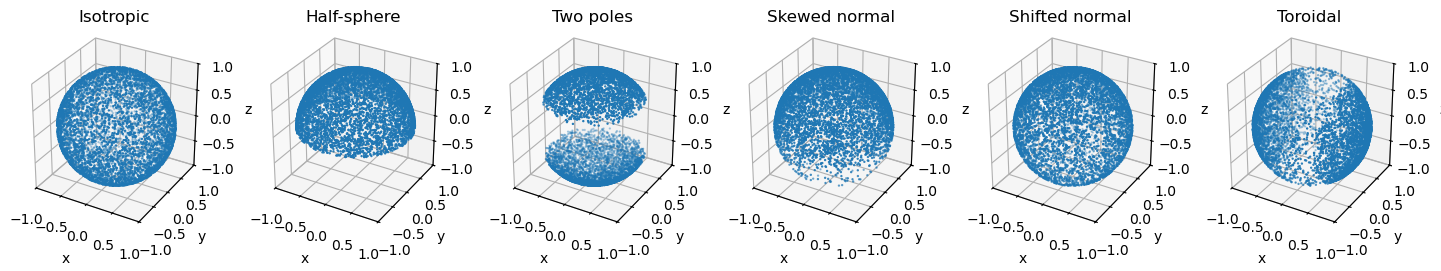

In [11]:
n_pts = 7000

pt_distribs = []
pt_distribs.append( generate_isotropic_pt_distrib(n_pts) )
pt_distribs.append( generate_half_sphere_pt_distrib(n_pts) )
pt_distribs.append( generate_two_poles_pt_distrib(n_pts) )
pt_distribs.append( generate_skewed_pt_distrib(n_pts, 3.0) )
pt_distribs.append( generate_shifted_pt_distrib(n_pts, 0.5) )
pt_distribs.append( generate_toroidal_pt_distrib(n_pts, 0.5) )
titles = ["Isotropic", "Half-sphere", "Two poles", "Skewed normal", "Shifted normal", "Toroidal"]

fig = plt.figure(
    # figsize=(3.36, 3.36)
    figsize=(18, 6)
    # , dpi=300
)
axes = fig.subplots(
    1,
    len(pt_distribs),
    subplot_kw=dict(projection="3d")
)

for pts, ax, title in zip(pt_distribs, axes, titles):
    add_subplot_of_cart_pts(pts, fig, ax)
    ax.set_title(title)
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_zlim((-1,1))
    ax.set_aspect("equal")

plt.show()

#### Skewed normal distribution

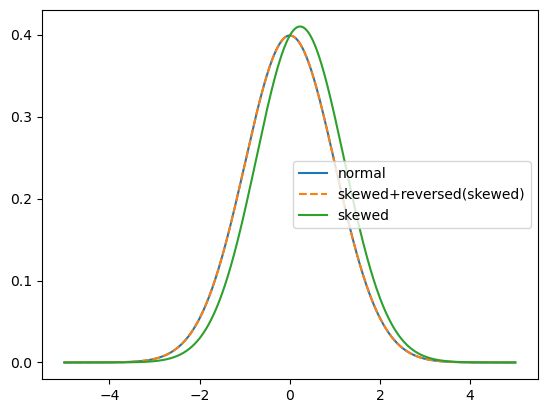

In [12]:
skewness_param = 0.3
xs = np.linspace(-5,5, 1000)
y1s = scipy_skewnorm.pdf(xs, skewness_param)
y2s = scipy_norm.pdf(xs)

fig = plt.figure()
ax = fig.subplots(1,1)

ax.plot(xs, y2s)
ax.plot(xs, (y1s + y1s[::-1]) / 2, ls="--")
ax.plot(xs, y1s)
ax.legend(["normal", "skewed+reversed(skewed)", "skewed"])

plt.show()

## Compute the 2-points correlation function

### Function definitions

In [13]:
def cartesian_to_spherical(xyz):
    """
    Parameters
    ----------
    xyz : numpy.ndarray
        3 by `n_pts` array

    Returns
    -------
    numpy.ndarray
        3 by `n_pts` array whose columns are the input points in spherical
        coordinates, ordering (r, theta, phi)
    """
    ptsnew = np.empty_like(xyz)
    xy = xyz[0, :]**2 + xyz[1, :]**2
    ptsnew[0, :] = np.sqrt(xy + xyz[2, :]**2)
    ptsnew[1, :] = np.arctan2(np.sqrt(xy), xyz[2, :]) # for elevation angle defined from Z-axis down
    #ptsnew[4, :] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[2, :] = np.arctan2(xyz[1, :], xyz[0, :])
    return ptsnew
# adapted from https://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion

In [71]:
def bin_pt_distrib(n_side, theta_angles, phi_angles):
    """
    Bin into a HEALPix number count map

    Parameters
    ----------
    n_side : int
        healpix nside
    theta_angles : float
    phi_angles : float

    Returns
    -------
    numpy.ndarray
        delta_map
    """

    npix = hp.nside2npix(n_side)

    # Initialize empty map
    count_map = np.zeros(npix, dtype=float)

    # Get pixel indices for each point
    pix = hp.ang2pix(n_side, theta_angles, phi_angles, nest=False)

    # Increment counts
    np.add.at(count_map, pix, 1.0)

    # OPTIONAL: convert to overdensity delta = (n - <n>)/<n>
    mean_n = np.mean(count_map)
    delta_map = (count_map - mean_n) / mean_n

    return delta_map


In [15]:
def compute_ps(map, lmax):
    """
    Parameters
    ----------
    map : numpy.ndarray
    lmax : int

    Returns
    -------
    tuple(numpy.ndarray, numpy.ndarray)
        (ells, cl)
    """
    # -------------------------
    # 3. Compute power spectrum C_ell using spherical harmonics
    # -------------------------
    # anafast internally performs a spherical-harmonic transform to get C_ell
    cl = hp.anafast(map, lmax=lmax)   # returns array from ell=0..lmax

    ells = np.arange(len(cl))
    return ells, cl

In [16]:
def ps_to_correlation_fun(ells, cl, nbin_theta):
    """
    Parameters
    ----------
    ells : numpy.ndarray
    cl : numpy.ndarray
    nbin_theta : int
        number of angle bins for xi(theta)

    Returns
    -------
    tuple(numpy.ndarray, numpy.ndarray)
        (theta_vals, xi)
    """
    # -------------------------
    # 4. Convert C_ell -> xi(theta)
    # -------------------------
    # The 2-point correlation function on the sphere is:
    #   xi(theta) = sum_{ell} (2ell+1)/(4pi) * C_ell * P_ell(cos theta)
    # where P_ell are Legendre polynomials.

    # Angle grid for xi(theta)
    theta_vals = np.linspace(0.0, np.pi, nbin_theta)       # radians
    mu_vals    = np.cos(theta_vals)

    # Precompute Legendre polynomials P_ell(mu) for all ell, mu
    P = np.zeros((len(ells), len(mu_vals)))
    for ell in ells:
        P[ell, :] = legendre(ell)(mu_vals)

    # Compute xi(theta)
    # shape: [theta] = sum_ell ( (2ell+1)/(4pi) * C_ell * P_ell(mu) )
    prefac = (2.0 * ells + 1.0) / (4.0 * np.pi)
    xi = np.dot(prefac * cl, P)    # length nbin_theta

    return (theta_vals, xi)

## Plots

### One-by-one

In [17]:
# -------------------------
# Parameters
# -------------------------
n_pts       = 1000000        # number of points on the sphere
n_side      = 64             # HEALPix resolution (must be power of 2)
l_max       = 3 * n_side - 1 # max multipole for anafast
n_bin_theta = 60             # number of angle bins for xi(theta)

# cart_pts = generate_isotropic_pt_distrib(n_pts)
# cart_pts = generate_half_sphere_pt_distrib(n_pts)
# cart_pts = generate_two_poles_pt_distrib(n_pts)
# cart_pts = generate_skewed_pt_distrib(n_pts, 0.001) # Imperceptible
# cart_pts = generate_skewed_pt_distrib(n_pts, 0.01) # Imperceptible
cart_pts = generate_skewed_pt_distrib(n_pts, 0.1) # Imperceptible
# cart_pts = generate_skewed_pt_distrib(n_pts, 1.0) # Barely noticeable
# cart_pts = generate_skewed_pt_distrib(n_pts, 2.0) # Clear
# cart_pts = generate_skewed_pt_distrib(n_pts, 10.0) # Almost half sphere

sph_pts    = cartesian_to_spherical(cart_pts)
delta_map  = bin_pt_distrib(n_side, sph_pts[1,:], sph_pts[2,:])
ls, cl     = compute_ps(delta_map, l_max)
thetas, xi = ps_to_correlation_fun(ls, cl, n_bin_theta)
theta_deg  = thetas * 180.0 / np.pi

/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


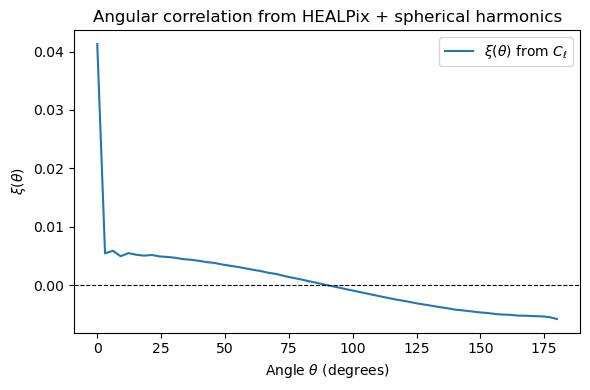

In [18]:
# -------------------------
# 5. Plot xi(theta) vs angle
# -------------------------

plt.figure(figsize=(6, 4))
plt.plot(theta_deg, xi, label=r"$\xi(\theta)$ from $C_\ell$")
plt.axhline(0.0, color="k", lw=0.8, ls="--")

plt.xlabel("Angle $\\theta$ (degrees)")
plt.ylabel(r"$\xi(\theta)$")
plt.title("Angular correlation from HEALPix + spherical harmonics")
plt.legend()
plt.tight_layout()
plt.show()

### All-at-once

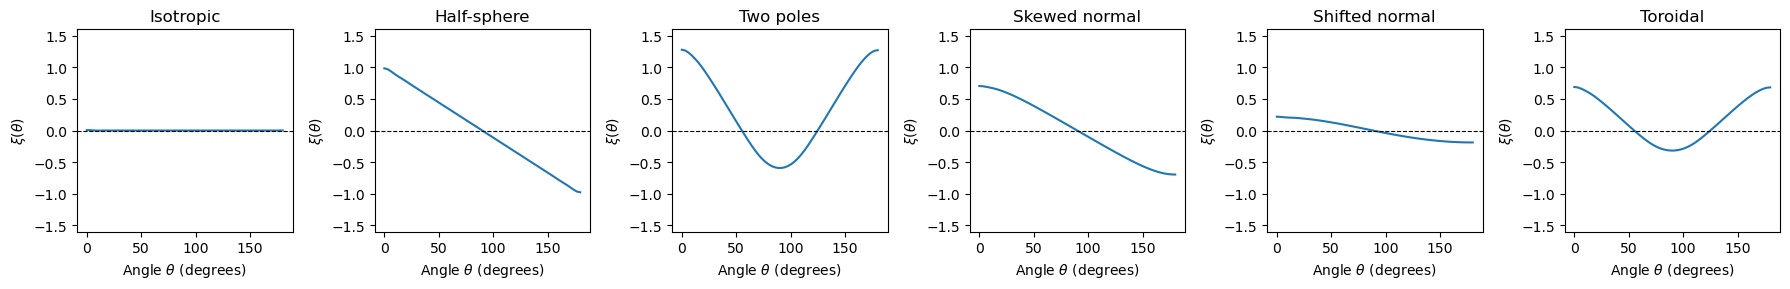

In [111]:
# -------------------------
# Parameters
# -------------------------
n_pts       = 100000
n_side      = 64             # HEALPix resolution (must be power of 2)
n_side      = 128
l_max       = 3 * n_side - 1 # max multipole for anafast
l_max       = 26 # max multipole for anafast
n_bin_theta = 60             # number of angle bins for xi(theta)

# Pt distributions
pt_distribs = []
pt_distribs.append( generate_isotropic_pt_distrib(n_pts) )
pt_distribs.append( generate_half_sphere_pt_distrib(n_pts) )
pt_distribs.append( generate_two_poles_pt_distrib(n_pts) )
pt_distribs.append( generate_skewed_pt_distrib(n_pts, 3.0) )
pt_distribs.append( generate_shifted_pt_distrib(n_pts, 0.5) )
pt_distribs.append( generate_toroidal_pt_distrib(n_pts, 0.5) )
titles = ["Isotropic", "Half-sphere", "Two poles", "Skewed normal", "Shifted normal", "Toroidal"]

# Figure and axes
fig = plt.figure(
    # figsize=(3.36, 3.36)
    figsize=(18, 3)
    # , dpi=300
)
axes = fig.subplots(
    1,
    len(pt_distribs)
)


for cart_pts, ax, title in zip(pt_distribs, axes, titles):
    sph_pts    = cartesian_to_spherical(cart_pts)
    delta_map  = bin_pt_distrib(n_side, sph_pts[1,:], sph_pts[2,:])
    ls, cl     = compute_ps(delta_map, l_max)
    thetas, xi = ps_to_correlation_fun(ls, cl, n_bin_theta)
    theta_deg  = thetas * 180.0 / np.pi

    ax.plot(theta_deg, xi, label=r"$\xi(\theta)$ from $C_\ell$")
    ax.axhline(0.0, color="k", lw=0.8, ls="--")

    ax.set_xlabel("Angle $\\theta$ (degrees)")
    ax.set_ylabel(r"$\xi(\theta)$")
    ax.set_title(title)

    # ylim_val= 3*np.median(abs(xi))
    # ax.set_ylim((-ylim_val,ylim_val))
    ax.set_ylim((-1.6,1.6)) # 2 seems to be a not-too-bad value

plt.tight_layout()
plt.show()

## Using repeated instances

### Function definitions

In [75]:
def compute_correlation_fun_wrt_deg(cart_pts, n_side, l_max, n_bin_theta):
    sph_pts    = cartesian_to_spherical(cart_pts)
    delta_map  = bin_pt_distrib(n_side, sph_pts[1,:], sph_pts[2,:])
    ls, cl     = compute_ps(delta_map, l_max)
    thetas, xi = ps_to_correlation_fun(ls, cl, n_bin_theta)
    theta_deg  = thetas * 180.0 / np.pi
    return theta_deg, xi

In [106]:
def compute_correlation_fun_mean_and_std(generating_function, n_pts, n_sets, n_side, l_max, n_bin_theta):
    theta_deg = np.linspace(0.0, np.pi, n_bin_theta) * 180.0 / np.pi
    xis = np.vstack([
        compute_correlation_fun_wrt_deg(generating_function(n_pts), n_side, l_max, n_bin_theta)[1]
        for _ in range(n_sets)
    ])
    mean_xis = xis.mean(axis=0)
    std_xis = xis.std(axis=0)
    # perc95_xis = np.percentile(xis, 95 ,axis=0)
    # perc05_xis = np.percentile(xis,  5 ,axis=0)
    return theta_deg, mean_xis, std_xis

In [ ]:
theta_deg, mean_xis, std_xis = compute_correlation_fun_mean_and_std(generate_isotropic_pt_distrib, 1024, 64, n_side, l_max, n_bin_theta)

/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: overflow encountered in scalar power
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/home/paul/.miniforge3/envs/gw-school-2025/lib/python3.11/site-packages/scipy/special/_orthogonal.py:2492: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


(64, 60)


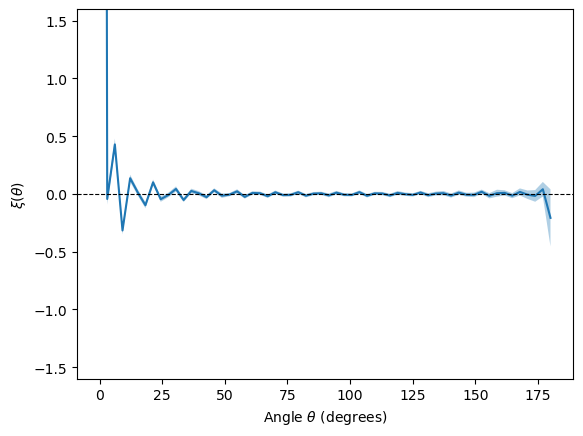

In [104]:
fig = plt.figure()
ax = fig.subplots(1,1)

ax.plot(theta_deg, mean_xis)
ax.fill_between(theta_deg, mean_xis+std_xis, mean_xis-std_xis, facecolor="C0", alpha=0.35)

ax.set_ylim(-1.6, 1.6)

ax.axhline(0.0, color="k", lw=0.8, ls="--")

ax.set_xlabel("Angle $\\theta$ (degrees)")
ax.set_ylabel(r"$\xi(\theta)$")

plt.show()

### All-at-once plot

Computing for Isotropic
Computing for Half-sphere
Computing for Two poles
Computing for Skewed normal
Computing for Shifted normal
Computing for Toroidal


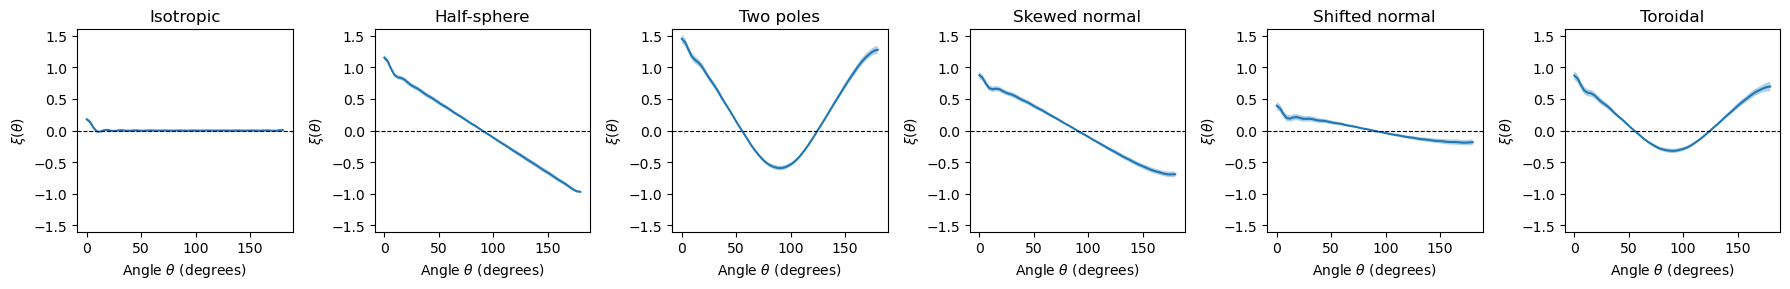

In [113]:
# -------------------------
# Parameters
# -------------------------
n_pts       = 4096
n_sets      = 128
n_side      = 64             # HEALPix resolution (must be power of 2)
n_side      = 128
l_max       = 3 * n_side - 1 # max multipole for anafast
l_max       = 26 # max multipole for anafast
n_bin_theta = 60             # number of angle bins for xi(theta)

# Pt distributions
generating_functions = [
    lambda n_pts: generate_isotropic_pt_distrib(n_pts),
    lambda n_pts: generate_half_sphere_pt_distrib(n_pts),
    lambda n_pts: generate_two_poles_pt_distrib(n_pts),
    lambda n_pts: generate_skewed_pt_distrib(n_pts, 3.0),
    lambda n_pts: generate_shifted_pt_distrib(n_pts, 0.5),
    lambda n_pts: generate_toroidal_pt_distrib(n_pts, 0.5)
]
titles = ["Isotropic", "Half-sphere", "Two poles", "Skewed normal", "Shifted normal", "Toroidal"]

# Figure and axes
fig = plt.figure(
    # figsize=(3.36, 3.36)
    figsize=(18, 3)
    # , dpi=300
)
axes = fig.subplots(
    1,
    len(pt_distribs)
)


for gen_fun, ax, title in zip(generating_functions, axes, titles):
    print(f"Computing for {title}")
    theta_deg, xi_means, xi_stds = compute_correlation_fun_mean_and_std(gen_fun, n_pts, n_sets, n_side, l_max, n_bin_theta)

    ax.plot(theta_deg, xi_means)
    ax.fill_between(theta_deg, xi_means+3*xi_stds, xi_means-3*xi_stds, facecolor="C0", alpha=0.35)

    ax.axhline(0.0, color="k", lw=0.8, ls="--")

    ax.set_xlabel("Angle $\\theta$ (degrees)")
    ax.set_ylabel(r"$\xi(\theta)$")
    ax.set_title(title)

    ax.set_ylim((-1.6,1.6)) # 2 seems to be a not-too-bad value

plt.tight_layout()
plt.show()

# Archives

```
# -------------------------
# 1. Generate isotropic points on the sphere
# -------------------------
def random_points_on_sphere(N):
    # Isotropic directions: cos(theta) uniform in [-1, 1], phi uniform in [0, 2pi)
    u   = np.random.uniform(-1.0, 1.0, N)
    phi = np.random.uniform(0.0, 2.0*np.pi, N)
    theta = np.arccos(u)   # colatitude in [0, pi]
    return theta, phi

theta, phi = random_points_on_sphere(Npts)

# theta = theta /2

# theta[theta > np.pi/4] = np.pi/2 + theta[theta > np.pi/4]

# -------------------------
# 2. Bin into a HEALPix number-count map
# -------------------------
# Initialize empty map
count_map = np.zeros(npix, dtype=float)

# Get pixel indices for each point
pix = hp.ang2pix(nside, theta, phi, nest=False)

# Increment counts
np.add.at(count_map, pix, 1.0)

# OPTIONAL: convert to overdensity delta = (n - <n>)/<n>
mean_n = np.mean(count_map)
delta_map = (count_map - mean_n) / mean_n

# -------------------------
# 3. Compute power spectrum C_ell using spherical harmonics
# -------------------------
# anafast internally performs a spherical-harmonic transform to get C_ell
cl = hp.anafast(delta_map, lmax=lmax)   # returns array from ell=0..lmax

ells = np.arange(len(cl))

# -------------------------
# 4. Convert C_ell -> xi(theta)
# -------------------------
# The 2-point correlation function on the sphere is:
#   xi(theta) = sum_{ell} (2ell+1)/(4pi) * C_ell * P_ell(cos theta)
# where P_ell are Legendre polynomials.

# Angle grid for xi(theta)
theta_vals = np.linspace(0.0, np.pi, nbin_theta)       # radians
mu_vals    = np.cos(theta_vals)

# Precompute Legendre polynomials P_ell(mu) for all ell, mu
P = np.zeros((len(ells), len(mu_vals)))
for ell in ells:
    P[ell, :] = legendre(ell)(mu_vals)

# Compute xi(theta)
# shape: [theta] = sum_ell ( (2ell+1)/(4pi) * C_ell * P_ell(mu) )
prefac = (2.0 * ells + 1.0) / (4.0 * np.pi)
xi = np.dot(prefac * cl, P)    # length nbin_theta

# -------------------------
# 5. Plot xi(theta) vs angle
# -------------------------
theta_deg = theta_vals * 180.0 / np.pi

plt.figure(figsize=(6, 4))
plt.plot(theta_deg, xi, label=r"$\xi(\theta)$ from $C_\ell$")
plt.axhline(0.0, color="k", lw=0.8, ls="--")

plt.xlabel("Angle $\\theta$ (degrees)")
plt.ylabel(r"$\xi(\theta)$")
plt.title("Angular correlation from HEALPix + spherical harmonics")
plt.legend()
plt.tight_layout()
plt.show()
```

# EoF